In [76]:
import numpy as np
import geopandas
import pandas as pd
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from tqdm import tqdm
import sklearn
from shapely.geometry import Polygon
from shapely import wkt
import re
import geopandas
from shapely import wkt

TODO: connect the arrays to the dataframes, so I can ID which datapoints are outliers

In [77]:
county_conn_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\county_conn.pkl') 
sci_dist_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\sci_dist.pkl')
geo_dist = np.load(r'C:\Users\mgm24\Documents\datasets\geo_dist.npy')
sci_dist_df.head(5)

fr_loc,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
user_loc,,,,,,,,,,,,,,,,,,,,,
1001,1.117710e-07,9.804210e-06,7.443744e-06,3.927421e-06,1.488184e-05,2.330883e-06,0.000001,0.000014,0.000009,0.000028,...,0.000573,0.000597,0.000418,0.000810,0.000730,0.000561,0.000344,0.000731,0.001028,0.001453
1003,9.804210e-06,3.172975e-07,1.997443e-05,1.228879e-05,1.490024e-05,3.052969e-05,0.000006,0.000016,0.000025,0.000026,...,0.000805,0.000371,0.000298,0.000522,0.000279,0.000634,0.000158,0.000521,0.000717,0.000442
1005,7.443744e-06,1.997443e-05,2.212110e-08,3.133912e-05,5.388512e-05,1.598885e-07,0.000004,0.000018,0.000006,0.000060,...,0.000738,0.000713,0.001277,0.001645,0.001242,0.001695,0.000350,0.002358,0.001427,0.001580
1007,3.927421e-06,1.228879e-05,3.133912e-05,2.434424e-08,4.175470e-06,1.999440e-05,0.000008,0.000012,0.000028,0.000023,...,0.002273,0.000667,0.000647,0.001488,0.000774,0.001898,0.001058,0.001502,0.001391,0.001019
1009,1.488184e-05,1.490024e-05,5.388512e-05,4.175470e-06,7.533211e-08,7.212926e-05,0.000034,0.000005,0.000038,0.000006,...,0.002457,0.000709,0.000665,0.000320,0.001105,0.000487,0.000668,0.001079,0.000875,0.000513


In [78]:
# vectorize pairwise distances
sci_dist_df = pd.melt(sci_dist_df, ignore_index=False) 
sci_dist = np.asarray(sci_dist_df['value'])
geo_dist = geo_dist.reshape((geo_dist.shape[0]**2,1)) #this reorganizes elements in the same way as pd.melt
sci_dist_df.head(5)

,fr_loc,value
user_loc,,
1001,1001,1.117710e-07
1003,1001,9.804210e-06
1005,1001,7.443744e-06
1007,1001,3.927421e-06
1009,1001,1.488184e-05


In [79]:
# Convert sci_dist into similarity measure
# sci_dist = 1/sci_dist

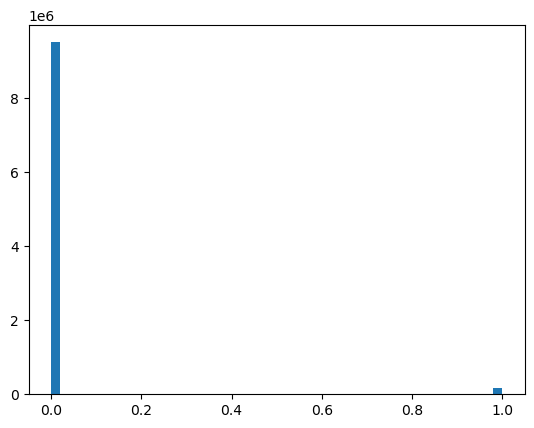

In [80]:
_ = plt.hist(sci_dist, bins=50)

Remove outlier points

In [81]:
print(geo_dist.shape)
# store original arrays for later indexing
og_geo_dist = geo_dist
og_sci_dist = sci_dist
geo_dist = np.delete(geo_dist, np.where(sci_dist>.1))
sci_dist = np.delete(sci_dist, np.where(sci_dist>.1))
# geo_dist = np.delete(geo_dist, np.where(sci_dist==1))
# sci_dist = np.delete(sci_dist, np.where(sci_dist==1))
print(geo_dist.shape)

(9659664, 1)
(9490482,)


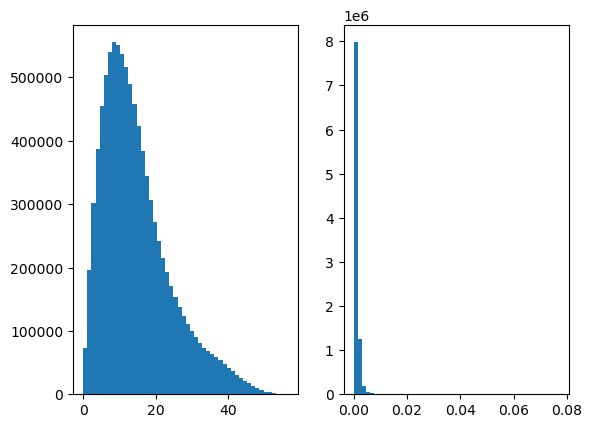

In [82]:
plt.subplot(1,2,1)
_ = plt.hist(geo_dist, bins=50)
plt.subplot(1,2,2)
_ = plt.hist(sci_dist, bins=50)

9487374


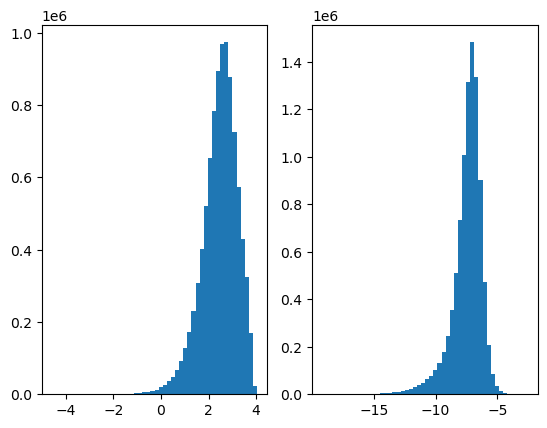

In [83]:
geodist_0idx = np.where(geo_dist>0)[0]
sci_dist = sci_dist[geodist_0idx]
geo_dist = geo_dist[geodist_0idx]
print(len(sci_dist))
plt.subplot(1,2,1)
_ = plt.hist(np.log(geo_dist), bins=50) # +.001 to prevent 0 errors
plt.subplot(1,2,2)
_ = plt.hist(np.log(sci_dist), bins=50)

Text(0, 0.5, 'Social distance')

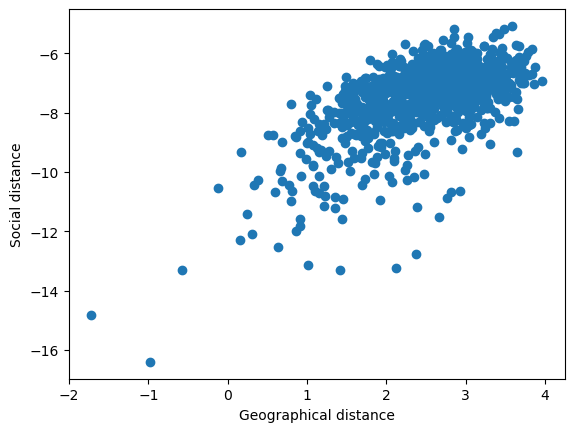

In [84]:
# Only plot a subsample (too many points otherwise) (MAYBE DELETE)
import random
samples = random.sample(range(len(sci_dist)), 1000)
plt.scatter(np.log(geo_dist[samples]), np.log(sci_dist[samples]))
plt.xlabel('Geographical distance')
plt.ylabel('Social distance')

Let's look at the relationship between geographical distance and social distance. Since we're only interested in when social distance is unexpectadly small when the counties are geographically distant, we'll remove the counties where the geographical distance is small.

Samples with a distance greater than 4.511534669127608: 8538636


Text(0, 0.5, 'Social distance')

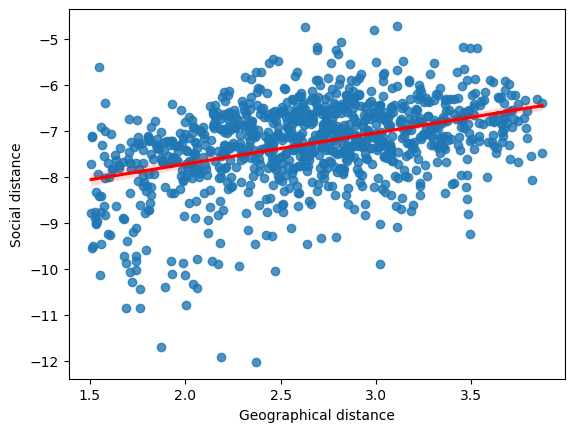

In [85]:
dist = np.percentile(geo_dist, 10)
print('Samples with a distance greater than '+str(dist)+': '+ str(np.sum(geo_dist>dist)))
geo_far = geo_dist[geo_dist>dist]
sci_far = sci_dist[geo_dist>dist]
samples = random.sample(range(len(sci_far)), 1000)
sns.regplot(x=np.log(geo_far[samples]), y=np.log(sci_far[samples]),
           line_kws={"color": "red"})
# plt.scatter(np.log(geo_far[samples]), np.log(sci_far[samples]))
plt.xlabel('Geographical distance')
plt.ylabel('Social distance')

TODO change: How effective is this model? Let's plot the diagnostic plots for this regression. Looking at the residual plots can also tell us about the outliers we're interested in.

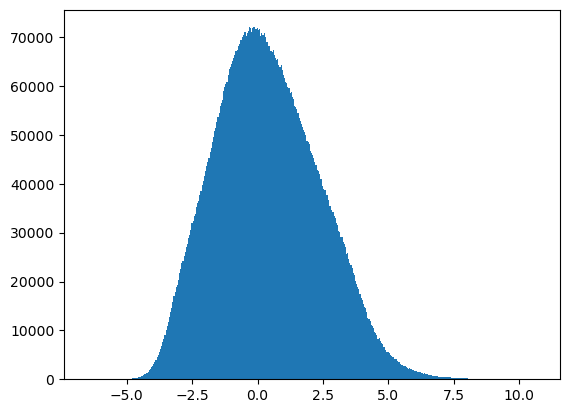

In [86]:
sci = 1/sci_far
results = sm.OLS(np.log(sci), np.log(geo_far)).fit()
residuals = results.resid
_ = plt.hist(residuals, bins=400)
# plt.xlim(-.003, .006)

The residuals have a heavy right tail -- meaning there is a lot of points where the actual social distance is much more than the predicted social distance -- the data we're intersted in!

In [87]:
np.where(geo_dist>dist)[0]
sci_dist_df.reset_index(inplace=True, level=0)
sci_dist_df

,user_loc,fr_loc,value
0,1001,1001,1.117710e-07
1,1003,1001,9.804210e-06
2,1005,1001,7.443744e-06
3,1007,1001,3.927421e-06
4,1009,1001,1.488184e-05
...,...,...,...
9659659,56037,56045,6.560604e-06
9659660,56039,56045,2.362502e-05
9659661,56041,56045,7.041658e-06
9659662,56043,56045,1.723419e-06


In [88]:
# drop the same elements from the df we dropped from the arrays
print(sci_dist_df.shape)
print(geo_dist.shape)
sci_dist_df.drop(sci_dist_df[sci_dist_df['value']>.1].index, inplace=True)
sci_dist_df.reset_index(inplace=True, drop=True)
print(sci_dist_df.shape)
sci_dist_df = sci_dist_df.iloc[geodist_0idx]
sci_dist_df.reset_index(inplace=True, drop=True)
print(sci_dist_df.shape)
sci_dist_df.drop(index=np.where(geo_dist<=dist)[0], inplace=True)
print(sci_dist_df.shape)

(9659664, 3)
(9487374,)
(9490482, 3)
(9487374, 3)
(8538636, 3)


C:\Users\mgm24\AppData\Local\Temp\ipykernel_9352\1687688963.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sci_dist_df.drop(index=np.where(geo_dist<=dist)[0], inplace=True)


In [89]:
sci_dist_df['resid'] = residuals
sci_dist_df.reset_index(inplace=True, drop=True)
sci_dist_df['geo_dist'] = geo_far

C:\Users\mgm24\AppData\Local\Temp\ipykernel_9352\1520572512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sci_dist_df['resid'] = residuals
C:\Users\mgm24\AppData\Local\Temp\ipykernel_9352\1520572512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sci_dist_df['geo_dist'] = geo_far


In [90]:
sci_dist_df

,user_loc,fr_loc,value,resid,geo_dist
0,4001,1001,0.001346,-1.583082,23.024480
1,4003,1001,0.000357,-0.267318,23.117718
2,4005,1001,0.000938,-1.472856,25.344027
3,4007,1001,0.000875,-1.282668,24.202042
4,4009,1001,0.001089,-1.396826,23.248064
...,...,...,...,...,...
8538631,56029,56045,0.000004,8.298385,5.066707
8538632,56035,56045,0.000004,8.000380,5.453757
8538633,56037,56045,0.000007,7.819271,4.832054
8538634,56039,56045,0.000024,5.962583,6.022835


In [91]:
og_df = sci_dist_df

Let's look at the results. We're interested in counties with a much smaller social distance than expected, or where the residual (x - predict(x)) is negative.

In [92]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data = county_data.set_index('fips')
county_data_select = county_data.loc[:, ['county', 'state']]
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'user_county', 'state':'user_state'})
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'fr_county', 'state':'fr_state'})
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df.sort_values('resid', ascending=True).head(10)

,value,resid,geo_dist,user_county,user_state,user_loc,fr_county,fr_state,fr_loc
44001,0.076923,-6.538157,32.610898,Gaines,TEXAS,48165,Bristol,RHODE ISLAND,44001
48165,0.076923,-6.538157,32.610898,Bristol,RHODE ISLAND,44001,Gaines,TEXAS,48165
51570,0.029412,-6.411034,44.880799,Colusa,CALIFORNIA,6011,Colonial Heights City,VIRGINIA,51570
6011,0.029412,-6.411034,44.880799,Colonial Heights City,VIRGINIA,51570,Colusa,CALIFORNIA,6011
1107,0.037037,-5.965982,34.653594,Colusa,CALIFORNIA,6011,Pickens,ALABAMA,1107
6011,0.037037,-5.965982,34.653594,Pickens,ALABAMA,1107,Colusa,CALIFORNIA,6011
51131,0.019231,-5.960793,44.447247,Morrow,OREGON,41049,Northampton,VIRGINIA,51131
41049,0.019231,-5.960793,44.447247,Northampton,VIRGINIA,51131,Morrow,OREGON,41049
13301,0.031250,-5.927395,36.440010,Nez Perce,IDAHO,16069,Warren,GEORGIA,13301
16069,0.031250,-5.927395,36.440010,Warren,GEORGIA,13301,Nez Perce,IDAHO,16069


In [93]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
county_data = geopandas.GeoDataFrame(county_data)
county_data = county_data.set_index('fips')

geometry_data = county_data.loc[:, ['geometry']]
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(geometry_data, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
# sci_dist_df['SCI'] = sci_dist_df['value']
# sci_dist_df['SDI'] = 1/sci_dist_df['value']
sci_dist_df = geopandas.GeoDataFrame(sci_dist_df)

In [94]:
sci_dist_df['SCI'] = 1/sci_dist_df['value'] 
## TODO: Should really create the SCI at the start, and work with it from the start. But last time I tried that, the results went to crap. Maybe my own error, maybe from cleaning it up
## rather than just using its raw value.

In [95]:
def plot_suprising_counties(sci_dist_df, user_loc, resid, n_counties=10):
    tc_df = sci_dist_df[sci_dist_df['user_loc']==user_loc]
    fig, ax = plt.subplots(figsize=(11,10))
    tc_df.plot('SCI', ax=ax)
    tc_df.sort_values(resid, ascending=False).head(n_counties).boundary.plot(color='red', ax=ax)

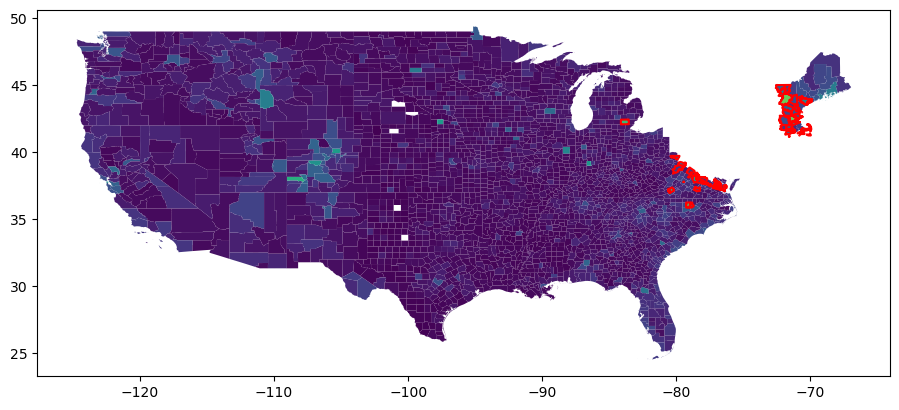

In [96]:
plot_suprising_counties(sci_dist_df, 36109, 'resid', 50)

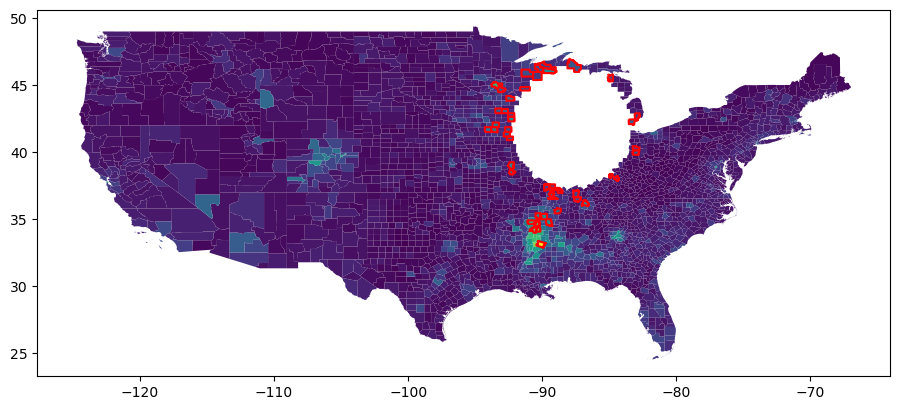

In [97]:
plot_suprising_counties(sci_dist_df, 17031, 'resid', 50)

This is problematic because of non linearities in the relationship.

In [22]:
density_info = pd.read_excel(r'C:\Users\mgm24\Documents\datasets\URAmericaMapCountyList.xlsx', header=3, index_col='CountyFIPS') #index_col='CountyFIPS'
density_info = density_info.loc[:, 'Density2016_SqMi']
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Density2016_SqMi':'user_density'})
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Density2016_SqMi':'fr_density'})

In [23]:
sci_dist_df['pairdensity_avg'] = (sci_dist_df['user_density'] + sci_dist_df['fr_density']) / 2

TODO: do a regression with population density
   
   Need to add geographic distances to this dataframe...
    
Maybe do a nearest neighbors ML algorithm, and look at errors relative to that


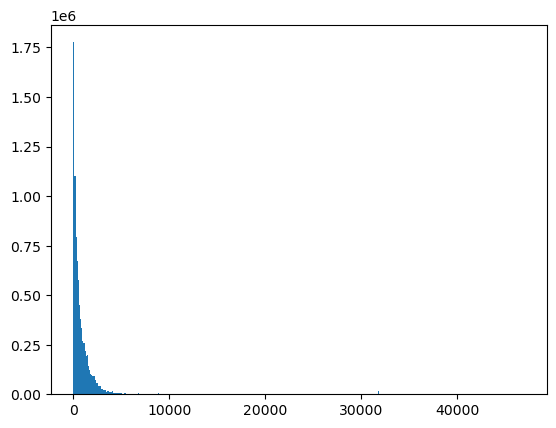

In [24]:
_ = plt.hist(sci_dist_df['pairdensity_avg'], bins=400)

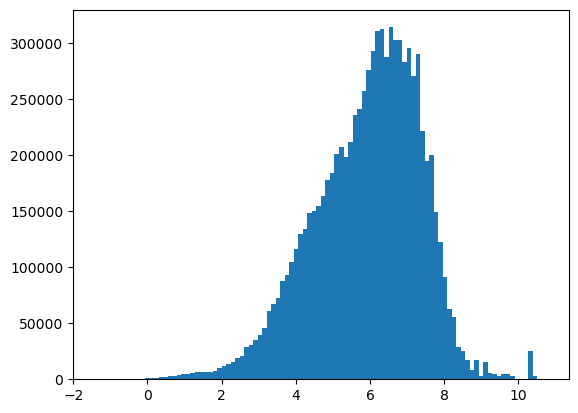

In [25]:
_ = plt.hist(np.log(sci_dist_df['pairdensity_avg']), bins=100)

<AxesSubplot:xlabel='log_pairdensity', ylabel='resid'>

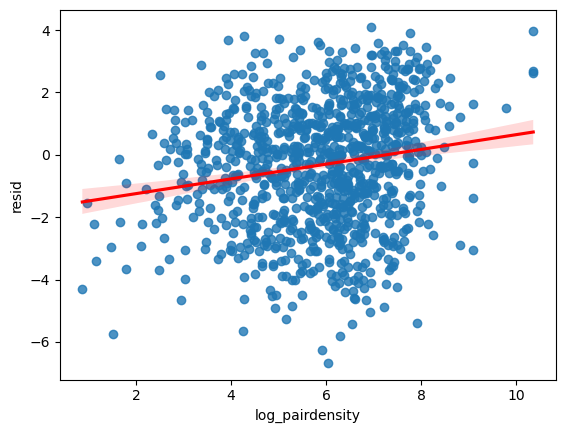

In [26]:
sci_dist_df['log_pairdensity'] = np.log(sci_dist_df['pairdensity_avg'])
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
sns.regplot(data=sci_dist_df.iloc[samples], x='log_pairdensity', y='resid',
           line_kws={"color": "red"})
# plt.xlim(0, 25)

There is indeed a relationship between the residuals and the population density of the counties: as the population density of the counties increases, the residual increases as well. This means lower population density leads the regression to predict a lower social distance than actually observed. This makes sense, as in population sparse regions, friendships are likely farther apart.

Now, let's run a regression including both geographic distances and population density.

In [45]:
sci_dist_df['log_geo_dist'] = np.log(sci_dist_df['geo_dist'])
results = sm.OLS(sci_dist_df['SCI'], sci_dist_df[['log_geo_dist','log_pairdensity']]).fit()

sci_dist_df['geo_density_resid'] = results.resid

Now, the county pairings with unexpectadly high social connections are all very far apart, which is more of the kinds of pairs we're interested in.

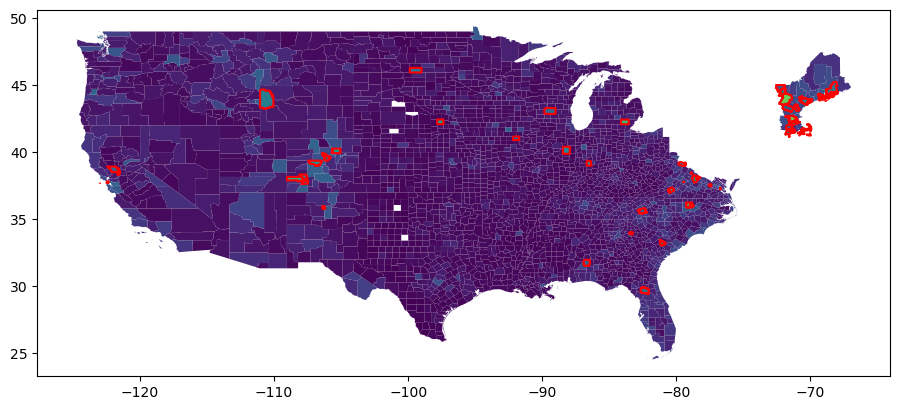

In [46]:
plot_suprising_counties(sci_dist_df, 36109, 'geo_density_resid', n_counties=50)

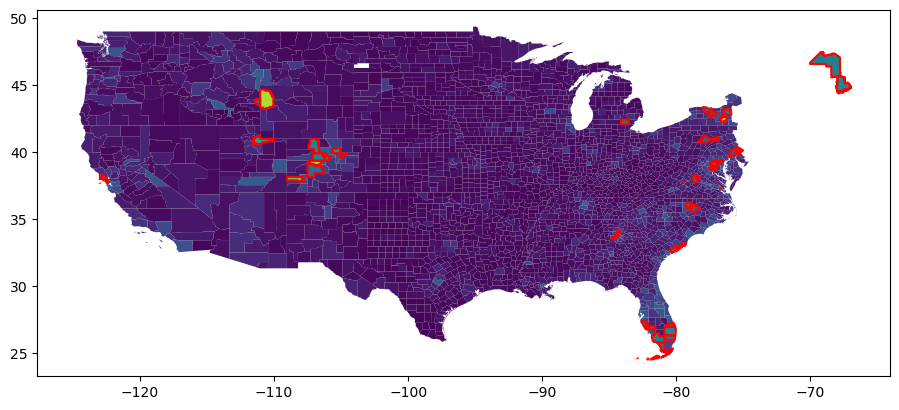

In [47]:
# Norfolk county?
plot_suprising_counties(sci_dist_df, 25021, 'geo_density_resid', n_counties=50)

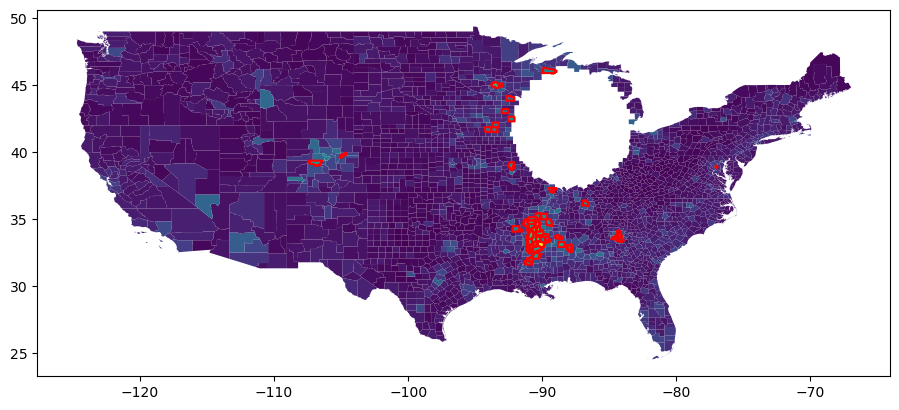

In [48]:
# cook county?
plot_suprising_counties(sci_dist_df, 17031, 'geo_density_resid', n_counties=50)

These results are cetainly a step forward. Still, they aren't perfect. The main problem in my opinion is the model really favors counties that are very far apart. Really, the relationship between social distance and geographical distance is likely nonlinear, such that after a certain geographical distance, social distances likely stop decreasing nearly as much. Let's try a regression capable of modeling these non-linearities: a K-nearest neighbors regression should do the trick.

In [34]:
n_neighbors = 100000
knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=50, weights='uniform')
# X = sci_dist_df[['log_geo_dist','log_pairdensity']]
X = sci_dist_df[['geo_dist']]
y = 1/sci_dist_df['value']
results = knn_model.fit(X, y)

In [35]:
if n_neighbors < 20:
    predictions = knn_model.predict(X)
    residuals = y - predictions
    sci_dist_df['knn_resid'] = residuals
else:
    # predict in batches (to avoid memory error)
    batch_size = 1000
    batches = np.arange(0, sci_dist_df.shape[0], batch_size)
    batches = batches[:-1] #remove last batch
    sci_dist_df.reset_index(inplace=True, drop=True)
    sci_dist_df['knn_resid'] = np.nan
    for batch in tqdm(batches, total=len(batches)):
        Xx = X[batch:batch+batch_size]
        Yy = y[batch:batch+batch_size]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch:batch+batch_size-1, 'knn_resid'] = np.asarray(Yy - predictions)

    Xx = X[batch+batch_size:]
    Yy = y[batch+batch_size:]
    predictions = knn_model.predict(Xx)
    sci_dist_df.loc[batch+batch_size:, 'knn_resid'] = np.asarray(Yy - predictions)

100%|██████████████████████████████████████████████████████████████████████████████| 8538/8538 [02:14<00:00, 63.70it/s]


In [36]:
sci_dist_df.sort_values('knn_resid', ascending=True).head(5)

,value,resid,geo_dist,user_county,user_state,fr_county,fr_state,geometry,user_density,user_loc,fr_density,fr_loc,pairdensity_avg,log_pairdensity,log_geo_dist,geo_density_resid,knn_resid
3985639,0.001931,-1.864582,5.358680,Tunica,MISSISSIPPI,Bates,MISSOURI,"POLYGON ((-94.61407 38.06735, -94.61394 38.118...",70.032239,28143,120.989556,29013,95.510898,4.559240,1.678718,0.001277,-140405.88
3939750,0.001931,-1.864582,5.358680,Bates,MISSOURI,Tunica,MISSISSIPPI,"POLYGON ((-90.58843 34.67097, -90.58201 34.680...",120.989556,29013,70.032239,28143,95.510898,4.559240,1.678718,0.001277,-140405.88
7912134,0.000615,-3.007839,5.358742,Fulton,OHIO,Bristol City,VIRGINIA,"POLYGON ((-82.23757 36.59824, -82.23344 36.600...",362.726879,39051,514.018343,51520,438.372611,6.083069,1.678729,-0.000028,-140162.00
5585420,0.000615,-3.007839,5.358742,Bristol City,VIRGINIA,Fulton,OHIO,"POLYGON ((-84.39955 41.70587, -84.39655 41.705...",514.018343,51520,362.726879,39051,438.372611,6.083069,1.678729,-0.000028,-140162.00
5715180,0.000907,-2.619494,5.358670,Patrick,VIRGINIA,Shelby,OHIO,"POLYGON ((-84.43464 40.35427, -84.43164 40.354...",41.234001,51141,934.450756,39149,487.842378,6.189992,1.678716,0.000265,-139986.84


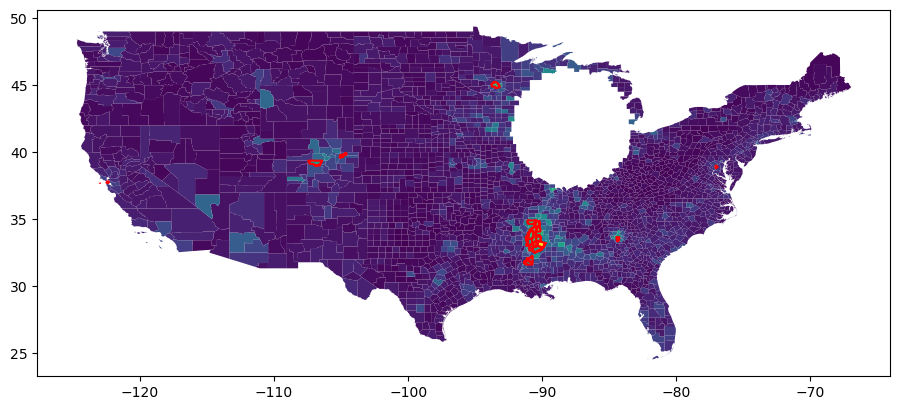

In [42]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_resid', n_counties=20)

This misses the Mississipi river counties, probably because in the west, far apart counties still have lots of connections, meaning the model is not that surprised to see counties at this distance have lots of connections.

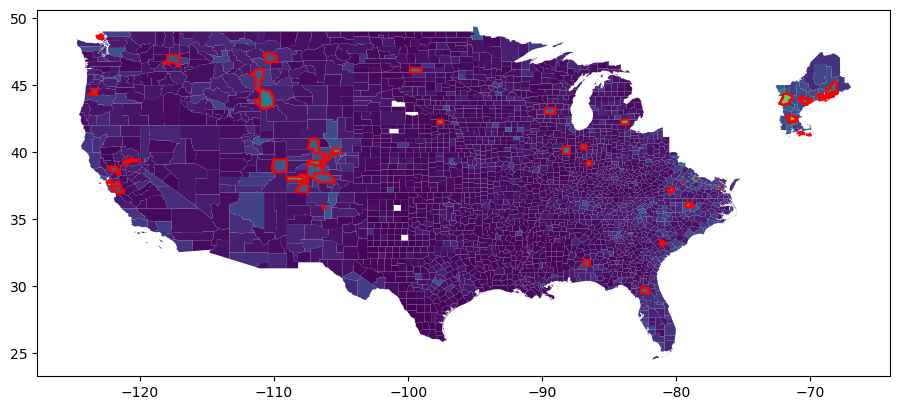

In [49]:
plot_suprising_counties(sci_dist_df, 36109, 'knn_resid', n_counties=50)

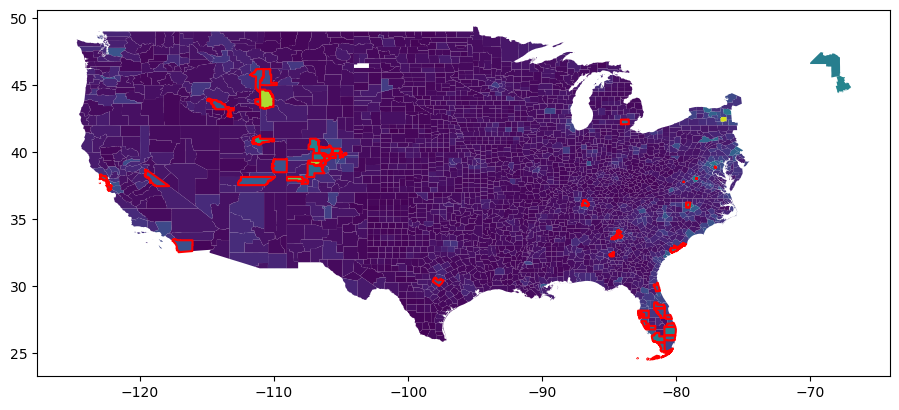

In [50]:
plot_suprising_counties(sci_dist_df, 25021, 'knn_resid', n_counties=50)

In [ ]:
# Get x, y coords
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
county_data = geopandas.GeoDataFrame(county_data)

# Convert r Polygon text to shapely polygon
for row_idx, row in county_data.iterrows():
    points = re.findall(r'-?\d+.\d+', row['geometry'].wkt)
    i = 0
    list_points = []
    while i < len(points):
        list_points.append((float(points[i]), float(points[i+1])))
        i+=2
    list_points

    county_shape = Polygon(list_points)
    county_center = county_shape.centroid
    center_points = re.findall(r'-?\d+.\d+', county_center.wkt)
    county_data.at[row_idx, 'center_long'] = float(center_points[0])
    county_data.at[row_idx, 'center_lat'] = float(center_points[1])

In [ ]:
# Try including x, y coords in model
county_data = county_data.set_index('fips')
center_loc = county_data.loc[:, ['center_long', 'center_lat']]
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(center_loc, how='left')
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'center_long':'user_center_long', 'center_lat':'user_center_lat'})
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(center_loc, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'center_long':'fr_center_long', 'center_lat':'fr_center_lat'})

In [ ]:
n_neighbors = 10000

knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform')
X = sci_dist_df[['user_center_long','user_center_lat','fr_center_long','fr_center_lat']]
y = sci_dist_df['value']
results = knn_model.fit(X, y)

if n_neighbors < 25:
    predictions = knn_model.predict(X)
    residuals = y - predictions
    sci_dist_df['knn_xy_resid'] = residuals

else: #predict in batch to avoid memory error
    batch_size = 1000
    batches = np.arange(0, sci_dist_df.shape[0], batch_size)
    batches = batches[:-1] #remove last batch
    sci_dist_df.reset_index(inplace=True, drop=True)
    sci_dist_df['knn_resid'] = np.nan
    for batch in tqdm(batches, total=len(batches)):
        Xx = X[batch:batch+batch_size]
        Yy = y[batch:batch+batch_size]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch:batch+batch_size-1, 'knn_xy_resid'] = np.asarray(Yy - predictions)

    Xx = X[batch+batch_size:]
    Yy = y[batch+batch_size:]
    predictions = knn_model.predict(Xx)
    sci_dist_df.loc[batch+batch_size:, 'knn_xy_resid'] = np.asarray(Yy - predictions)


In [ ]:
sci_dist_df.sort_values('knn_xy_resid', ascending=True).head(20)

In [ ]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_xy_resid', n_counties=10)

Now, let's try plotting the connectivity data